In [1]:
import json
import os
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append("../../")

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, average_precision_score
from tqdm import tqdm

from utils.metrics import match_annotations_and_predictions
from utils.ltt_utils import create_x_y
%load_ext autoreload
%autoreload 2

In [2]:
ANNOT_PATH = "data/01_ovary_cuts/roi_annotation_united/annotations_test.json"
PRED_PATH = "data/04_model_predictions/efficientdet/results.json"

In [3]:
with open(ANNOT_PATH, "r") as f:
    annotations = json.load(f)

with open(PRED_PATH, "r") as f:
    predictions = json.load(f)

In [4]:
predictions["4C_e"].keys()

dict_keys(['roi2', 'roi0', 'roi1', 'roi3', 'roi5', 'roi6', 'roi4'])

In [5]:
slide_id = np.random.randint(0, len(annotations))
slide_name = "4C_e" # list(annotations.keys())[slide_id]
roi_id = np.random.randint(0, len(annotations[slide_name]))
roi_name = "roi2" # list(annotations[slide_name].keys())[roi_id]

print(slide_name, roi_name)

4C_e roi2


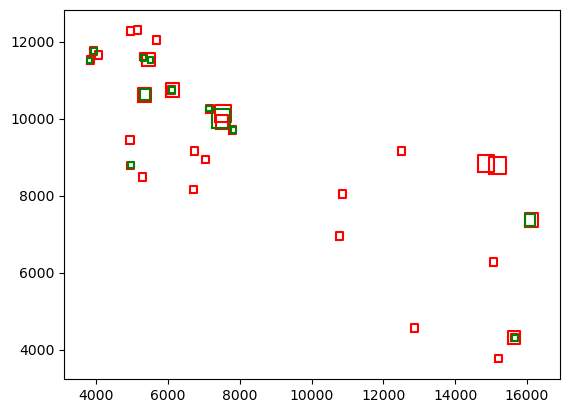

In [6]:
for i, pred_box in enumerate(predictions[slide_name][roi_name]["bboxes"]):
    if predictions[slide_name][roi_name]["scores"][i] > 0.0:
        x1, y1, x2, y2 = np.array(pred_box)
        plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color="red")

for gt_box in annotations[slide_name][roi_name]["bboxes"]:
    x1, y1, x2, y2 = np.array(gt_box)
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color="green")
# plt.imshow(img)
    

# mAP

In [7]:
IOU_TH = .3
X_pmf, y_pmf = create_x_y(
    predictions.keys(), annotations, predictions,
    iou_th=IOU_TH, classes="PMF", with_depth=False
)
X_primary, y_primary = create_x_y(
    predictions.keys(), annotations, predictions,
    iou_th=IOU_TH, classes="Primary", with_depth=False
)
X_secondary, y_secondary = create_x_y(
    predictions.keys(), annotations, predictions,
    iou_th=IOU_TH, classes="Secondary", with_depth=False
)


In [8]:
ap_pmf = average_precision_score(y_pmf, X_pmf > 0)
ap_primary = average_precision_score(y_primary, X_primary > 0)
ap_secondary = average_precision_score(y_secondary, X_secondary > 0)

mAP = np.mean([ap_pmf, ap_primary, ap_secondary])
mAP


0.3281404694265608

# Precision-Recall curve for different depth

In [9]:
X, y = create_x_y(
    predictions.keys(), annotations, predictions,
    iou_th=IOU_TH, classes="all", with_depth=True
)

In [10]:
precisions = []
recalls = []
step = 0.05
depth_ths = np.arange(.35, 1 + step, step)
for th_depth in tqdm(depth_ths):
    precisions_depth = []
    recalls_depth = []
    for th_obj in np.arange(0, 1, 0.01):
        X_depth = X[:, :, 0] * (X[:, :, 1] <= th_depth)
        precision = [precision_score(y[i], X_depth[i] >= th_obj, zero_division=1) for i in range(len(X))]
        recall = [recall_score(y[i], X_depth[i] >= th_obj, zero_division=1) for i in range(len(X))]
        precisions_depth.append(np.mean(precision))
        recalls_depth.append(np.mean(recall))
    precisions.append(precisions_depth)
    recalls.append(recalls_depth)


  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [02:04<00:00,  8.92s/it]


# Plot

In [11]:
len(precisions), len(precisions[0])

(14, 100)

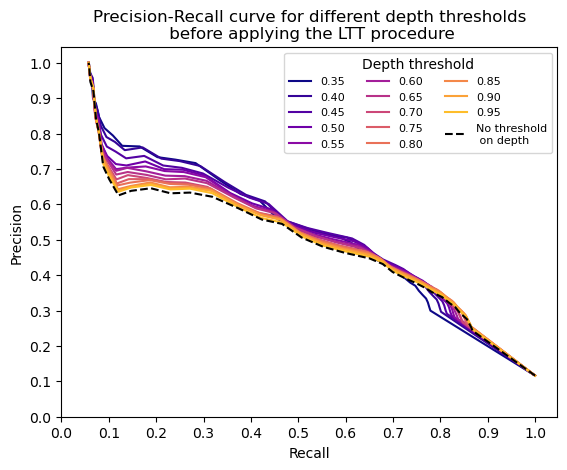

In [17]:
for i in range(len(precisions) - 1):
    d = depth_ths[i]
    plt.plot(recalls[i], precisions[i], label=f"{d:.2f}", color=plt.cm.plasma(i / len(precisions)))
plt.plot(recalls[-1], precisions[-1], label=f"No threshold\n on depth", color="black", linestyle="--")
# put legend outside of the plot
plt.legend(loc='upper right', title="Depth threshold", ncol=3, fontsize=8)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xticks(np.arange(0, 1.1, .1))
plt.yticks(np.arange(0, 1.1, .1))
plt.title("Precision-Recall curve for different depth thresholds\n before applying the LTT procedure")
plt.savefig("precision_recall_depth.pdf", bbox_inches="tight")
plt.show()

# Depth PR curve

In [16]:
precisions = []
recalls = []
step = 0.05

for th_depth in np.arange(0, 1, 0.01):
    X_depth = X[:, :, 1]
    precision = [precision_score(y[i], X_depth[i] <= th_depth, zero_division=1) for i in range(len(X))]
    recall = [recall_score(y[i], X_depth[i] <= th_depth, zero_division=1) for i in range(len(X))]
    
    precisions.append(np.mean(precision))
    recalls.append(np.mean(recall))

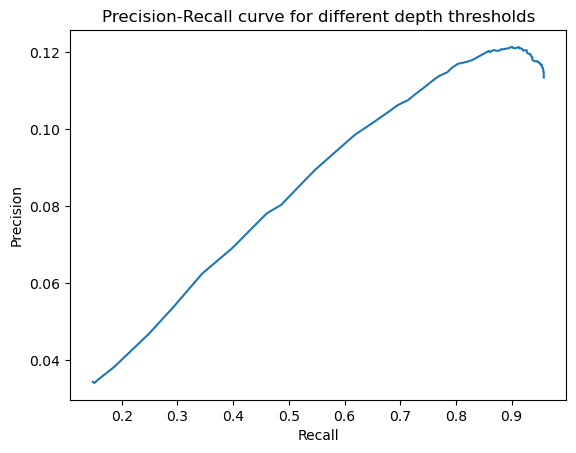

In [18]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve for different depth thresholds")
plt.show()

In [15]:
recalls

[0.9575790153561449]

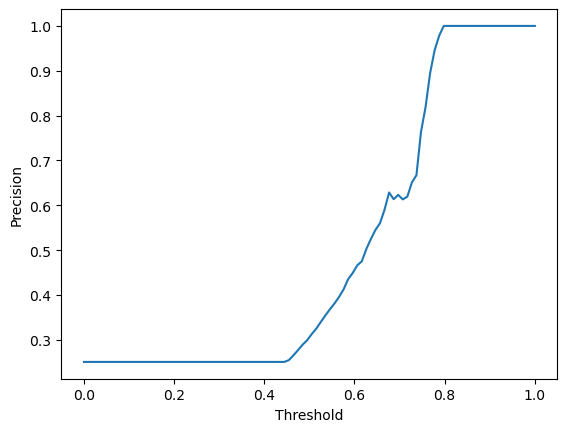

In [38]:
# plt.plot(np.linspace(0, 1, 100), precisions, label="boxewise")
plt.plot(np.linspace(0, 1, 100), precisions_avg, label="average")
# plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Precision")
plt.show()

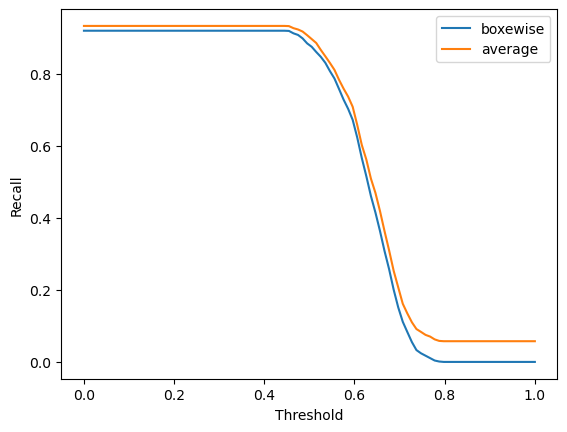

In [39]:
plt.plot(np.linspace(0, 1, 100), recalls, label="boxewise")
plt.plot(np.linspace(0, 1, 100), recalls_avg, label="average")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.show()

# Confusion Matrix

In [40]:
ID_FOR_CM = {
    "PMF": 1,
    "Primary": 2,
    "Secondary": 3
}

In [44]:
cm = np.zeros((4, 4))
TH = .1
for slide_name in annotations.keys():
    for roi_name in annotations[slide_name].keys():
        gt_boxes = np.array(annotations[slide_name][roi_name]["bboxes"])
        pred_boxes = np.array(predictions[slide_name][roi_name]["bboxes"])
        pred_boxes = pred_boxes[np.array(predictions[slide_name][roi_name]["scores"]) > 0.]
        matched_annot, matched_pred = match_annotations_and_predictions(gt_boxes, pred_boxes, min_iou=0.3)
        for i in range(len(matched_annot)):
            cm[ID_FOR_CM[annotations[slide_name][roi_name]["classes"][matched_annot[i]]], ID_FOR_CM[predictions[slide_name][roi_name]["classes"][matched_pred[i]]]] += 1
        for i in range(len(gt_boxes)):
            if i not in matched_annot:
                cm[ID_FOR_CM[annotations[slide_name][roi_name]["classes"][i]], 0] += 1
        for i in range(len(pred_boxes)):
            if i not in matched_pred:
                cm[0, ID_FOR_CM[predictions[slide_name][roi_name]["classes"][i]]] += 1



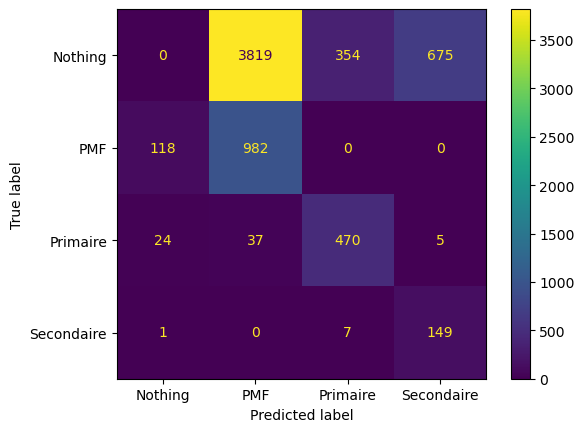

In [45]:
ConfusionMatrixDisplay(cm, display_labels=["Nothing", "PMF", "Primaire", "Secondaire"]).plot(values_format=".0f")

In [46]:
precisions = np.zeros(4)
recalls = np.zeros(4)

for i in range(1, 4):
    precisions[i] = cm[i, i] / np.sum(cm[:, i])
    recalls[i] = cm[i, i] / np.sum(cm[i, :])

precisions, recalls


(array([0.        , 0.20297644, 0.56558363, 0.17973462]),
 array([0.        , 0.89272727, 0.87686567, 0.94904459]))

In [47]:
precision = np.sum(np.diag(cm)) / np.sum(cm)
precision

0.24107815088089143

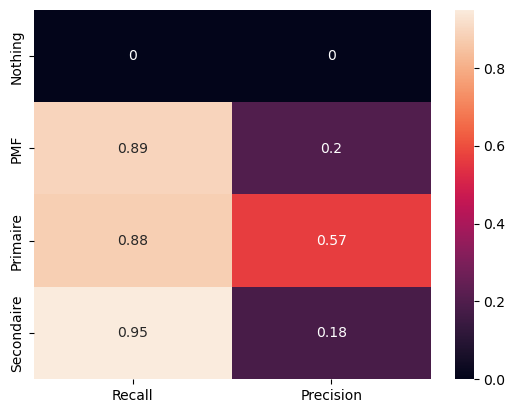

In [48]:
Index= ['Nothing', 'PMF', 'Primaire', 'Secondaire']
Cols = ['Recall', 'Precision']

table = np.column_stack((recalls.reshape(-1, 1), precisions.reshape(-1, 1)))
df = pd.DataFrame(table, index=Index, columns=Cols)

ax = plt.axes()
sns.heatmap(df, annot=True, ax = ax)
plt.show()